## Outline

- main research question: what role has the 3P shot played in determining team's success?
- ways to answer:
    - % of all points attempted/scored that are 3P shots
    - compare each team's probability of winning to its expected 3P %: how predictive is a better ev on 3p% (compared to FG%) in determining a team's success? -> show line plots with team trajectories, and regression line
    - can also run a regression each season, then show the R^2 for 3P% and 3PA vs FG% and FGA
- additional question: has it broken the game? are teams able to respond by defending better against 3s?
    - look at specific teams: are there teams that stand out as having much lower 3P% from opponents?
    - look at 3P% over time vs % of all shots that are 3P: does % fall after the spike in usage of 3P?

Write-Up Outline:
- Increasing importance of 3P shots
    - line plots of 3P as % of shots and % of pts
- has it broken the NBA? probably not
    - correlations with season win % isn't that much higher than FGM
    - 3P% hasn't moved that much over last 15 years
    - top defenses are responding, suppressing other teams ability to utilize the 3P shot

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('team_data_clean_v3.csv')

In [3]:
df[['TEAM_home', 'TEAM_away', 'GAME_DATE_home', 'PTS_home', 'PTS_away']].head(5)

,TEAM_home,TEAM_away,GAME_DATE_home,PTS_home,PTS_away
0,HOU,ORL,2021-12-03,118,116
1,ATL,PHI,2021-12-03,96,98
2,BKN,MIN,2021-12-03,110,105
3,IND,MIA,2021-12-03,104,113
4,WAS,CLE,2021-12-03,101,116


In [4]:
df.columns

Index(['TEAM_home', 'GAME_DATE_home', 'W/L_home', 'MIN_home', 'PTS_home',
       'FGM_home', 'FGA_home', 'FG%_home', '3PM_home', '3PA_home', '3P%_home',
       'FTM_home', 'FTA_home', 'FT%_home', 'OREB_home', 'DREB_home',
       'REB_home', 'AST_home', 'STL_home', 'BLK_home', 'TOV_home', 'PF_home',
       '+/-_home', 'TEAM_away', 'MATCHUP_away', 'W/L_away', 'MIN_away',
       'PTS_away', 'FGM_away', 'FGA_away', 'FG%_away', '3PM_away', '3PA_away',
       '3P%_away', 'FTM_away', 'FTA_away', 'FT%_away', 'OREB_away',
       'DREB_away', 'REB_away', 'AST_away', 'STL_away', 'BLK_away', 'TOV_away',
       'PF_away', '+/-_away'],
      dtype='object')

### Increasing importance of 3P

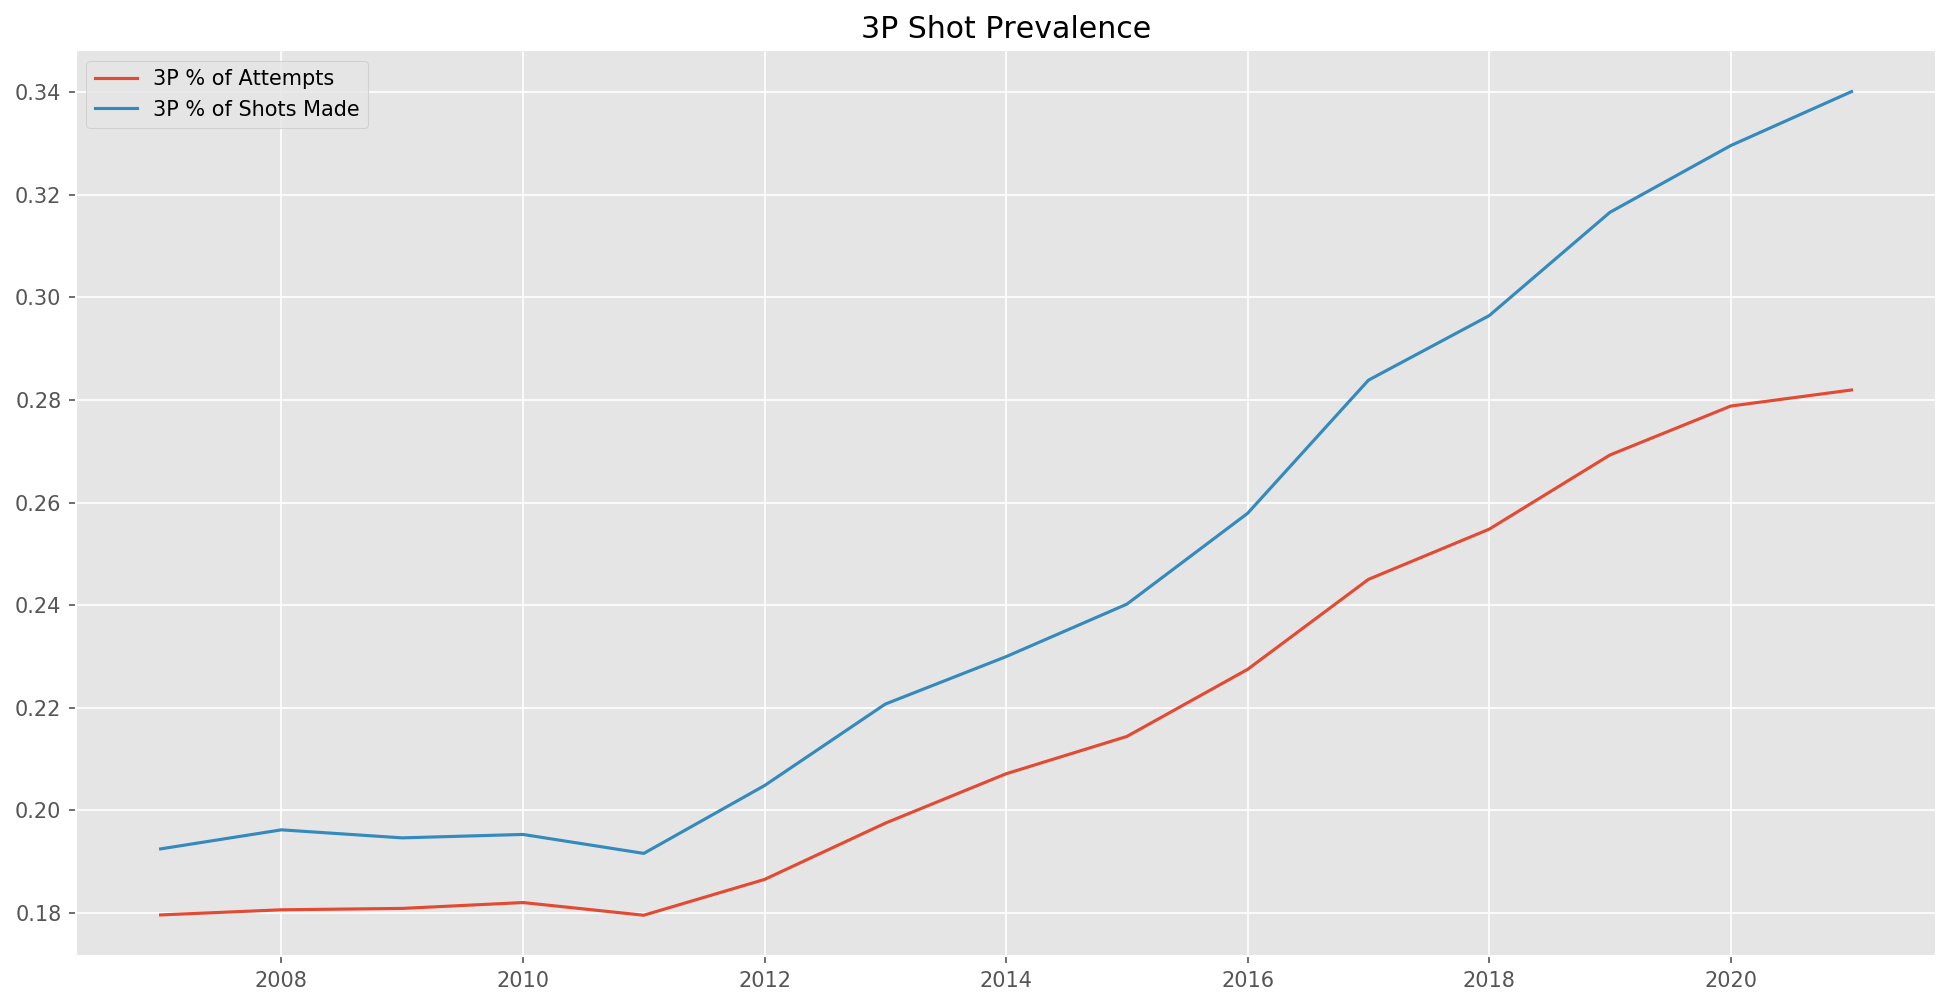

In [57]:
#% of all attempted shots that are 3P
df['year'] = pd.DatetimeIndex(df['GAME_DATE_home']).year
df['tot_att'] = df['FGA_home'] + df['3PA_home'] + df['FGA_away'] + df['3PA_away']
df['tot_3PA%'] = (df['3PA_home'] + df['3PA_away']) / df['tot_att']
df['tot_3P%'] = 3 * (df['3PM_home'] + df['3PM_away']) / (df['PTS_home'] + df['PTS_away'])

plt.figure(figsize=(16, 8), dpi=150)

x1 = df.groupby('year').mean()['tot_3PA%']
x2 = df.groupby('year').mean()['tot_3P%']
#df.groupby('year').mean()['tot_3PA%'].plot()
plt.plot(x1)
plt.plot(x2)
plt.title('3P Shot Prevalence')
plt.legend(['3P % of Attempts', '3P % of Shots Made'])
plt.savefig('3p_shot_prevalence.png')
plt.show()

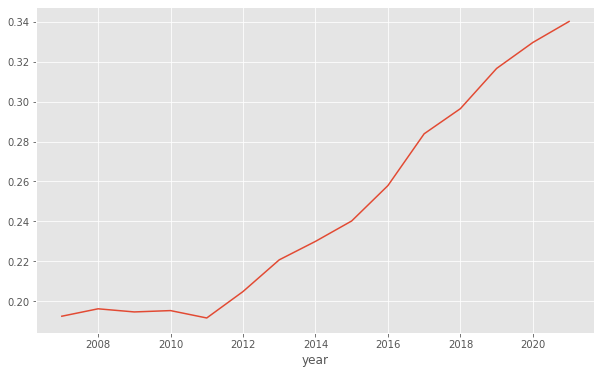

In [6]:
plt.rcParams["figure.figsize"] = (10,6)
df.groupby('year').mean()['tot_3P%'].plot()

In [7]:
#how much of a role does 3P% play in determining team's success?

#function to compute win rates, 3P%, 3PA, FG%, FGA for a given team, grouped by year
def yrly_team_stats(team_abbr):
    home_cols = ['year', 'GAME_DATE_home', 'FGA_home', 'FG%_home', 'FGM_home', '3PA_home', '3P%_home', '3PM_home', 'W/L_home']
    away_cols = ['year', 'GAME_DATE_home', 'FGA_away', 'FG%_away', 'FGM_away', '3PA_away', '3P%_away', '3PM_away', 'W/L_away']
    
    home_rename_dict = {'FGA_home': 'FGA', 'FG%_home': 'FG%', 'FGM_home': 'FGM', '3PA_home': '3PA', 
                        '3P%_home': '3P%', '3PM_home': '3PM', 'W/L_home': 'W/L'}
    away_rename_dict = {'FGA_away': 'FGA', 'FG%_away': 'FG%', 'FGM_away': 'FGM', '3PA_away': '3PA', 
                        '3P%_away': '3P%', '3PM_away': '3PM', 'W/L_away': 'W/L'}
    
    #retrieve home and away data for team_abbr
    home_df = df.loc[df['TEAM_home'] == team_abbr, home_cols].rename(columns=home_rename_dict)
    away_df = df.loc[df['TEAM_away'] == team_abbr, away_cols].rename(columns=away_rename_dict)
    
    #concatenate together to form single dataframe
    all_df = pd.concat([home_df, away_df])
    
    #convert win/loss into 1/0
    all_df['W/L'] = all_df['W/L'].map({'W': 1, 'L': 0})
    
    return all_df

#function to average out between years, returning values for mean game 3PM, FGM, and season win %

def yr_avged_data(df, team_abbr):
    ret_df = df.groupby('year').mean()[['W/L', '3PM', 'FGM', '3P%']].reset_index()
    ret_df['TEAM'] = team_abbr
    return ret_df


In [8]:
#concatenate for all teams in league
nba_all_yrly = pd.concat([yr_avged_data(yrly_team_stats(team_abbr), team_abbr) for team_abbr in df['TEAM_home'].unique()])

In [9]:
x = nba_all_yrly.loc[nba_all_yrly['year'] == 2021].corr()
print(x.iloc[2, 1], x.iloc[3, 1])
x

0.4157390447012032 0.6611922538357006


,year,W/L,3PM,FGM,3P%
year,NaN,NaN,NaN,NaN,NaN
W/L,NaN,1.000000,0.415739,0.661192,0.805371
3PM,NaN,0.415739,1.000000,0.130494,0.614335
FGM,NaN,0.661192,0.130494,1.000000,0.492047
3P%,NaN,0.805371,0.614335,0.492047,1.000000


In [10]:
yr_list, tp_list, fg_list = [], [], []
for year in sorted(nba_all_yrly['year'].unique()):
    tp = nba_all_yrly.loc[nba_all_yrly['year'] == year].corr().iloc[2, 1]
    fg = nba_all_yrly.loc[nba_all_yrly['year'] == year].corr().iloc[3, 1]
    yr_list.append(year)
    tp_list.append(tp)
    fg_list.append(fg)

In [11]:
corr_df = pd.DataFrame({'year': yr_list, '3PM_corr': tp_list, 'FGM_corr': fg_list})

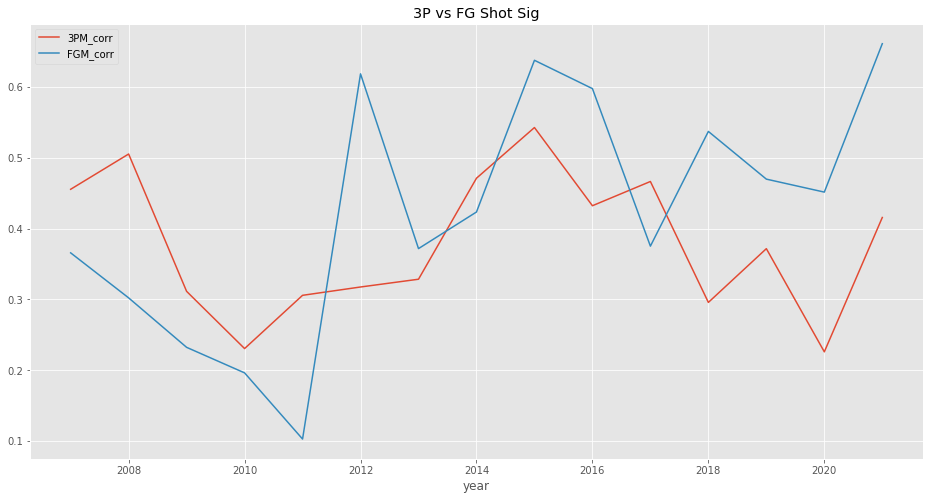

In [55]:
plt.rcParams["figure.figsize"] = (16,8)

plot = corr_df.plot('year', ['3PM_corr', 'FGM_corr'])
plt.title('3P vs FG Shot Sig')

plot.figure.savefig('3p_fg_sig.png')

In [44]:
yrs.to_list()

[2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021]

In [13]:
len(df['TEAM_home'].unique())

33

### has it broken NBA?

In [14]:
df_q2 = df.copy()

In [15]:
#look at 3P% over time
df_q2['3P%_avg'] = (df_q2['3P%_home'] * df_q2['3PA_home'] + df_q2['3P%_away'] * df_q2['3PA_away']) / (df_q2['3PA_home'] + df_q2['3PA_away'])

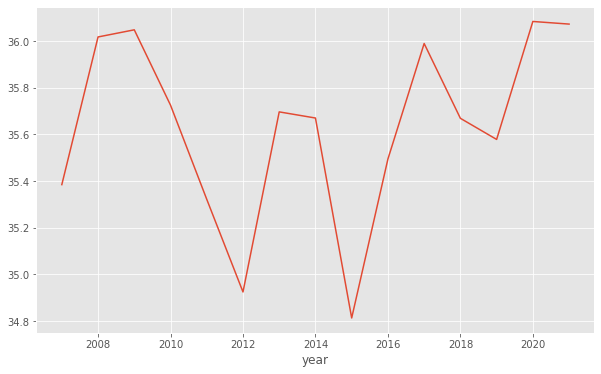

In [16]:
plt.rcParams["figure.figsize"] = (10,6)
df_q2.groupby('year').mean()['3P%_avg'].plot()

In [17]:
#are there teams that have figured out how to defend threes?

#get mean seasonal 3p% for each team
nba_all_yrly

,year,W/L,3PM,FGM,3P%,TEAM
0,2007,0.483871,6.741935,35.838710,33.596774,HOU
1,2008,0.726190,7.333333,36.190476,35.435714,HOU
2,2009,0.634146,7.719512,37.134146,36.024390,HOU
3,2010,0.469136,8.024691,38.012346,36.846914,HOU
4,2011,0.537037,8.407407,38.925926,35.490741,HOU
...,...,...,...,...,...,...
3,2010,0.216867,5.156627,34.301205,34.134940,NJN
4,2011,0.301887,6.000000,36.226415,34.918868,NJN
5,2012,0.338710,7.758065,34.500000,33.672581,NJN
0,2007,0.290323,4.838710,37.419355,35.229032,SEA


In [18]:
#merge dataframes to get each home team's season 3P%
perc_df = df_q2.merge(nba_all_yrly[['3P%', '3PM', 'TEAM', 'year']], left_on=['year', 'TEAM_home'], right_on=['year', 'TEAM'])

#rename columns to denote that they are season avgs for home team
perc_df.drop(['TEAM'], axis=1, inplace=True)
perc_df.rename(columns={'3P%': 'yr_3P%_home', '3PM': 'yr_3PM_home'}, inplace=True)

#merge for away teams
perc_df = perc_df.merge(nba_all_yrly[['3P%', '3PM', 'TEAM', 'year']], left_on=['year', 'TEAM_away'], right_on=['year', 'TEAM'])

perc_df.drop(['TEAM'], axis=1, inplace=True)
perc_df.rename(columns={'3P%': 'yr_3P%_away', '3PM': 'yr_3PM_away'}, inplace=True)

In [19]:
perc_df.loc[(perc_df['TEAM_away'] == 'HOU') & (perc_df['year'] == 2021)].columns.to_list()

['TEAM_home',
 'GAME_DATE_home',
 'W/L_home',
 'MIN_home',
 'PTS_home',
 'FGM_home',
 'FGA_home',
 'FG%_home',
 '3PM_home',
 '3PA_home',
 '3P%_home',
 'FTM_home',
 'FTA_home',
 'FT%_home',
 'OREB_home',
 'DREB_home',
 'REB_home',
 'AST_home',
 'STL_home',
 'BLK_home',
 'TOV_home',
 'PF_home',
 '+/-_home',
 'TEAM_away',
 'MATCHUP_away',
 'W/L_away',
 'MIN_away',
 'PTS_away',
 'FGM_away',
 'FGA_away',
 'FG%_away',
 '3PM_away',
 '3PA_away',
 '3P%_away',
 'FTM_away',
 'FTA_away',
 'FT%_away',
 'OREB_away',
 'DREB_away',
 'REB_away',
 'AST_away',
 'STL_away',
 'BLK_away',
 'TOV_away',
 'PF_away',
 '+/-_away',
 'year',
 'tot_att',
 'tot_3PA%',
 'tot_3P%',
 '3P%_avg',
 'yr_3P%_home',
 'yr_3PM_home',
 'yr_3P%_away',
 'yr_3PM_away']

In [20]:
#function to take perc_df and a team neame and generate data frame to compare team's 3P% in season avg, vs against team_abbr

def get_3P_diff(team_abbr):
    home_df = perc_df.loc[perc_df['TEAM_home'] == team_abbr, ['yr_3P%_away', '3P%_away', 'year', 'GAME_DATE_home']]
    home_df.rename(columns={'yr_3P%_away': 'opp_yr_3P%', '3P%_away': 'opp_game_3P%'}, inplace=True)

    away_df = perc_df.loc[perc_df['TEAM_away'] == team_abbr, ['yr_3P%_home', '3P%_home', 'year', 'GAME_DATE_home']]
    away_df.rename(columns={'yr_3P%_home': 'opp_yr_3P%', '3P%_home': 'opp_game_3P%'}, inplace=True)
    
    all_df = pd.concat([home_df, away_df]).sort_values(by='GAME_DATE_home')
    all_df['TEAM'] = team_abbr
    
    #diff column shows how much worse a team scored in 3P%s in total season vs against team_abbr
    all_df['3P%_diff'] = all_df['opp_yr_3P%'] - all_df['opp_game_3P%']
    return all_df

In [21]:
#function to take df and find opponent's mean 3P% for each team
def get_opp_3P(team_abbr):
    home_df = df.loc[df['TEAM_home'] == team_abbr, ['year', 'GAME_DATE_home', '3P%_away']]
    home_df.rename(columns={'3P%_away': '3P%'}, inplace=True)
    
    away_df = df.loc[df['TEAM_away'] == team_abbr, ['year', 'GAME_DATE_home', '3P%_home']]
    away_df.rename(columns={'3P%_home': '3P%'}, inplace=True)
    
    all_df = pd.concat([home_df, away_df]).sort_values(by='GAME_DATE_home')
    all_df['TEAM'] = team_abbr
    return all_df

In [22]:
all_opp_3P = pd.concat([get_opp_3P(tm) for tm in df['TEAM_home'].unique()])

In [23]:
all_3P_diff = pd.concat([get_3P_diff(tm) for tm in df['TEAM_home'].unique()])

In [24]:
all_3P_diff.groupby(['TEAM', 'year']).mean().loc['UTA']#.sort_values(by='3P%_diff', ascending=False)

,opp_yr_3P%,opp_game_3P%,3P%_diff
year,,,
2007,35.541864,35.842424,-0.300561
2008,35.532089,34.802439,0.729650
2009,35.856957,36.170370,-0.313414
2010,35.824516,34.568675,1.255841
2011,35.284457,40.118868,-4.834411
2012,34.883197,35.320213,-0.437016
2013,35.610342,35.792857,-0.182515
2014,35.718370,38.246250,-2.527880
2015,34.910027,36.138272,-1.228244


In [25]:
all_opp_3P.groupby(['TEAM', 'year']).mean().loc["BKN"]

,3P%
year,
2012,35.609677
2013,37.500000
2014,35.541463
2015,36.189157
2016,36.980488
2017,36.563953
2018,36.313095
2019,34.342105
2020,34.368889


In [26]:
all_opp_3P.loc[all_opp_3P['TEAM'] == 'GSW']

,year,GAME_DATE_home,3P%,TEAM
16989,2007,2007-10-30,45.5,GSW
16970,2007,2007-11-02,38.9,GSW
16959,2007,2007-11-03,75.0,GSW
16946,2007,2007-11-06,37.5,GSW
16927,2007,2007-11-08,41.7,GSW
...,...,...,...,...
88,2021,2021-11-21,40.5,GSW
58,2021,2021-11-24,28.6,GSW
47,2021,2021-11-26,34.2,GSW
33,2021,2021-11-28,32.1,GSW


In [27]:
all_opp_3P['TEAM'].unique()

array(['HOU', 'ATL', 'BKN', 'IND', 'WAS', 'POR', 'PHX', 'MEM', 'TOR',
       'NYK', 'LAC', 'MIL', 'OKC', 'NOP', 'BOS', 'MIA', 'ORL', 'SAC',
       'UTA', 'SAS', 'DAL', 'CHI', 'MIN', 'PHI', 'LAL', 'CLE', 'GSW',
       'DEN', 'CHA', 'DET', 'NOH', 'NJN', 'SEA'], dtype=object)

BOS
GSW
MEM
DAL
MIL


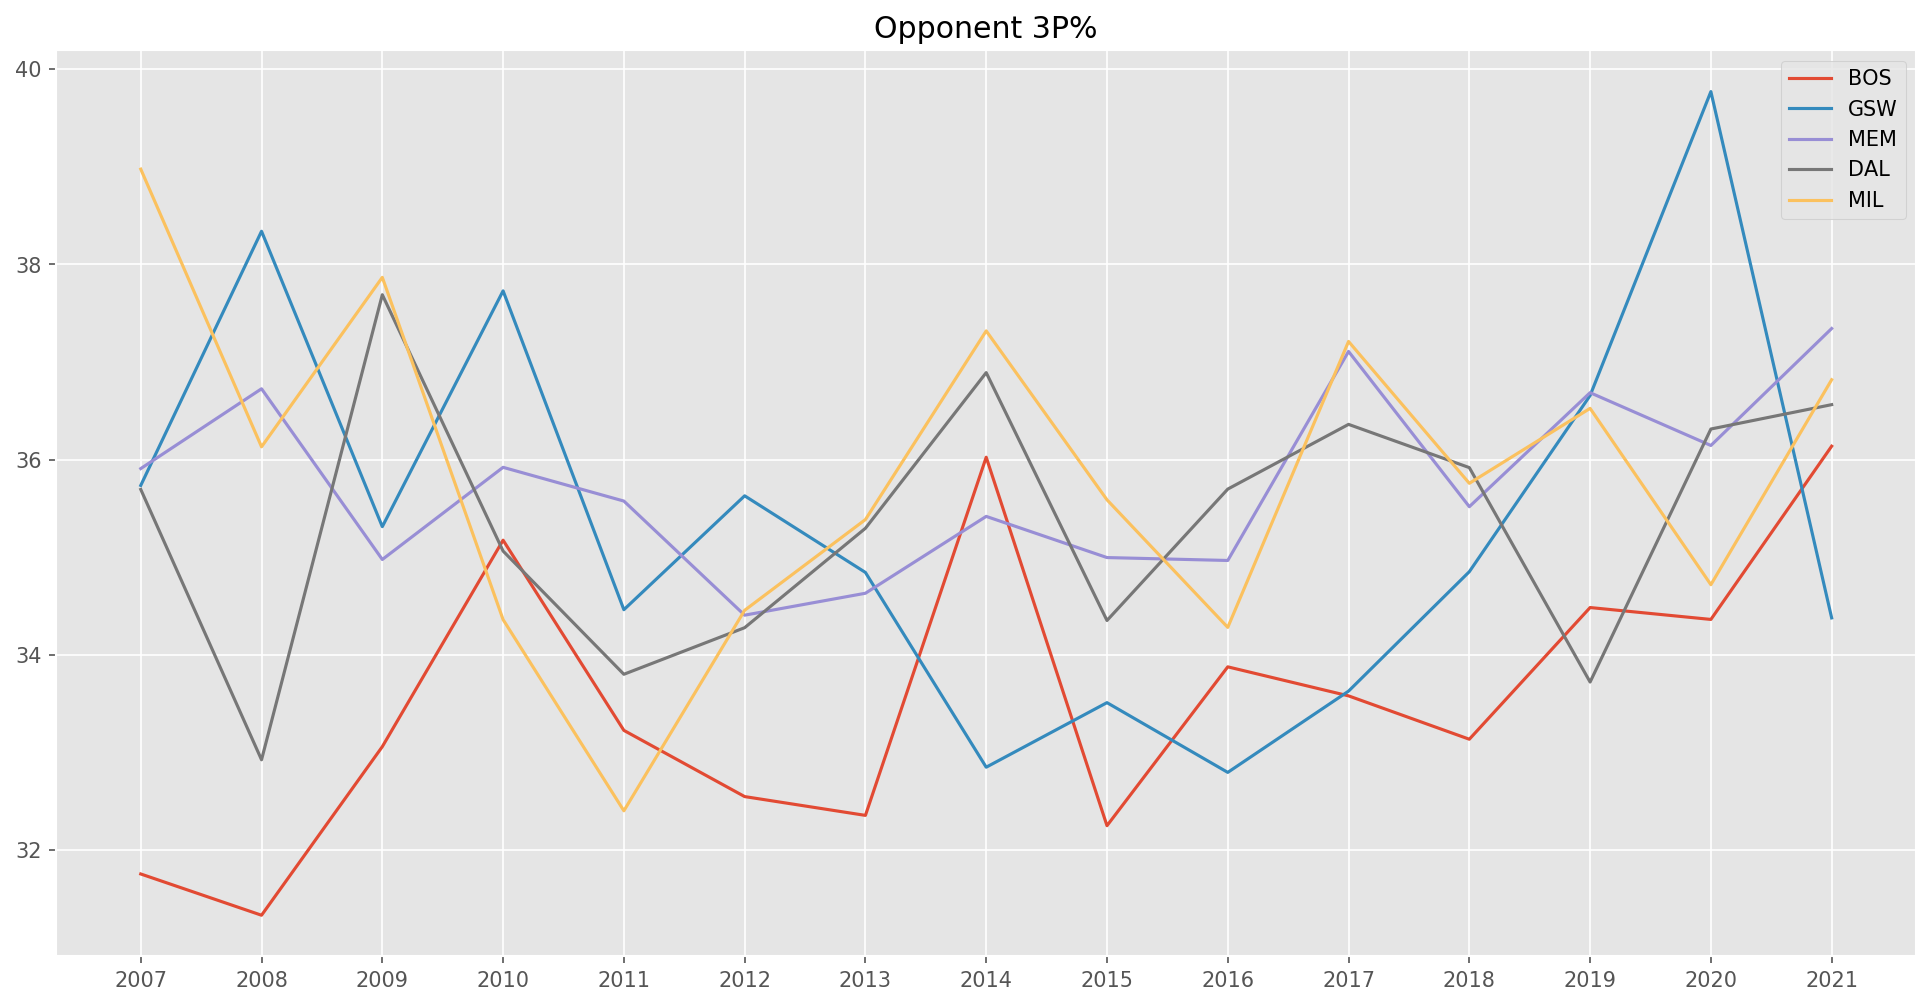

In [60]:
#plot time series of all teams opponent 3P%
plt.figure(figsize=(16, 8), dpi=150)


plotting_df = all_opp_3P.groupby(['TEAM', 'year']).mean()
#team_list = list(all_opp_3P['TEAM'].unique())
team_list = ['BOS', 'GSW', 'MEM', 'DAL', 'MIL']
for tm in team_list:
    print(tm)
    plt.plot(plotting_df.loc[tm].index, plotting_df.loc[tm]['3P%'], label=tm)

plt.xticks(ticks=plotting_df.loc['HOU'].index)
plt.legend(team_list)
plt.title('Opponent 3P%')
plt.savefig('defense.png')
plt.show()

In [29]:
list(all_opp_3P['TEAM'].unique())

['HOU',
 'ATL',
 'BKN',
 'IND',
 'WAS',
 'POR',
 'PHX',
 'MEM',
 'TOR',
 'NYK',
 'LAC',
 'MIL',
 'OKC',
 'NOP',
 'BOS',
 'MIA',
 'ORL',
 'SAC',
 'UTA',
 'SAS',
 'DAL',
 'CHI',
 'MIN',
 'PHI',
 'LAL',
 'CLE',
 'GSW',
 'DEN',
 'CHA',
 'DET',
 'NOH',
 'NJN',
 'SEA']

In [30]:
list(plotting_df.loc['HOU'].index)

[2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021]